In [90]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import json
import os

### Loading Data and Preprocessing

In [91]:
file_path = "../data/monthly_data/monthly_data.json" 
with open(file_path, "r") as file:
    data = json.load(file)
df = pd.DataFrame(data)

# preprocessing
df["month"] = pd.to_datetime(df["month"])
df = df[df["status"].isin(["graduated", "retired"])]

numeric_features = [
    "avg_response_time", "avg_first_response_time", 
    "accepted_prs", "avg_time_to_acceptance", "rejected_prs",
    "avg_time_to_rejection", "unresolved_prs", "avg_thread_length",
    "new_prs", "new_comments", "active_devs"
]

# Check if total_active_devs is null in any project - may signify no active developers for PROJECT
# has_nan = df["total_active_devs"].isna().any()
# print(has_nan)

df["total_active_devs"] = df["total_active_devs"].replace(0, np.nan) # this is for sanity only, there are no empty total_active_devs (has been checked)
for feature in numeric_features:
    df[feature] = df[feature] / df["total_active_devs"]

# Fill missing values with 0
df[numeric_features] = df[numeric_features].fillna(0)
df["status"] = df["status"].map({"graduated": 1, "retired": 0})
df.head(10)

,listid,repo,status,month,avg_response_time,avg_first_response_time,active_devs,total_active_devs,accepted_prs,avg_time_to_acceptance,rejected_prs,avg_time_to_rejection,unresolved_prs,avg_thread_length,new_prs,new_comments
0,51,ACE,1,2014-09-01,0.0,0.0,0.2,5,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0
1,51,ACE,1,2014-10-01,0.0,0.0,0.0,5,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0
2,51,ACE,1,2014-11-01,0.0,0.0,0.0,5,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0
3,51,ACE,1,2014-12-01,0.0,0.0,0.0,5,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0
4,51,ACE,1,2015-01-01,0.0,0.0,0.0,5,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0
5,51,ACE,1,2015-02-01,0.0,0.0,0.0,5,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0
6,51,ACE,1,2015-03-01,0.0,0.0,0.0,5,0.0,0.0,0.2,3376272.8,0.0,0.0,0.0,0.0
7,51,ACE,1,2016-02-01,0.0,0.0,0.2,5,0.0,0.0,2.2,33260.2,0.0,0.0,2.2,0.0
8,51,ACE,1,2018-07-01,0.0,0.0,0.2,5,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0
9,51,ACE,1,2018-08-01,0.0,0.0,0.0,5,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0


### Forming data for model

In [92]:
X = df[numeric_features]
y = df["status"]

### Testing RobustScaler

In [93]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print(X_scaled_df.head(10))
print(X_scaled.max(axis=0))  # Meaningful spread of values is checked
print(X_scaled.min(axis=0))  # Should be 0 for inactive months



   avg_response_time  avg_first_response_time  accepted_prs  \
0                0.0                      0.0           0.0   
1                0.0                      0.0           0.0   
2                0.0                      0.0           0.0   
3                0.0                      0.0           0.0   
4                0.0                      0.0           0.0   
5                0.0                      0.0           0.0   
6                0.0                      0.0           0.0   
7                0.0                      0.0           0.0   
8                0.0                      0.0           0.0   
9                0.0                      0.0           0.0   

   avg_time_to_acceptance  rejected_prs  avg_time_to_rejection  \
0                     0.0           0.0               0.000000   
1                     0.0           0.0               0.000000   
2                     0.0           0.0               0.000000   
3                     0.0           0.0   

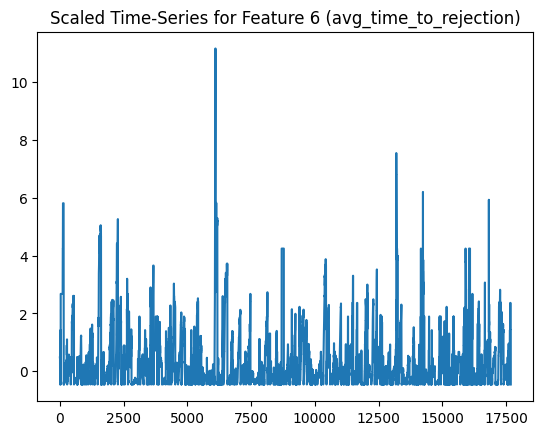

In [94]:
import matplotlib.pyplot as plt
plt.plot(X_scaled[:, 6])  # Choose a feature index
plt.title("Scaled Time-Series for Feature 6 (avg_time_to_rejection)")
plt.show()

### Testing MinMaxScaler


In [95]:
X_log = np.log1p(X)  # log1p(x) = log(1 + x) prevents issues with log(0)
scaler = MinMaxScaler(feature_range=(0.1,0.9))
X_scaled_min = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled_min, columns=X.columns)
print(X_scaled_df.head(10))
print(X_scaled_min.max(axis=0))  # Meaningful spread of values is checked
print(X_scaled_min.min(axis=0))  # Should be 0 for inactive months

   avg_response_time  avg_first_response_time  accepted_prs  \
0                0.1                      0.1           0.1   
1                0.1                      0.1           0.1   
2                0.1                      0.1           0.1   
3                0.1                      0.1           0.1   
4                0.1                      0.1           0.1   
5                0.1                      0.1           0.1   
6                0.1                      0.1           0.1   
7                0.1                      0.1           0.1   
8                0.1                      0.1           0.1   
9                0.1                      0.1           0.1   

   avg_time_to_acceptance  rejected_prs  avg_time_to_rejection  \
0                     0.1          0.10               0.100000   
1                     0.1          0.10               0.100000   
2                     0.1          0.10               0.100000   
3                     0.1          0.10   

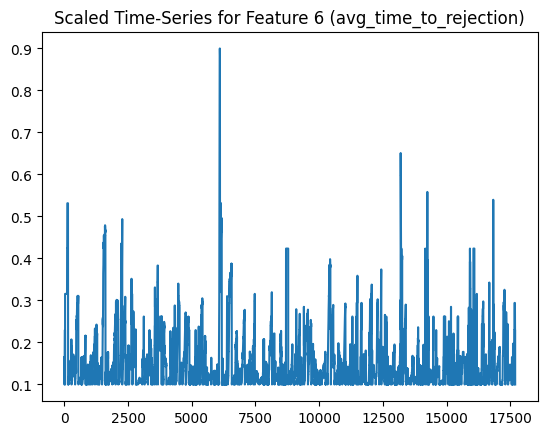

In [96]:
import matplotlib.pyplot as plt
plt.plot(X_scaled_min[:, 6])  # Choose a feature index
plt.title("Scaled Time-Series for Feature 6 (avg_time_to_rejection)")
plt.show()

### Lasso Regression Analysis (using RobustScaler)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [98]:
lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97702356e-0...
       1.38488637e+02, 1.66810054e+02, 2.00923300e+02, 2.42012826e+02,
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
        cv=5, random_state=42)

In [99]:
lasso = LassoCV(alphas=[lasso_cv.alpha_]) # choosing best alpha for Lasso
lasso.fit(X_train, y_train)

LassoCV(alphas=[np.float64(0.000774263682681127)])

In [100]:
# Extract feature importance (including zero coefficients)
feature_importance = pd.Series(lasso.coef_, index=numeric_features)
feature_importance = feature_importance.sort_values(ascending=False, key=abs)

In [101]:
plt.figure(figsize=(12, 6))
feature_importance.plot(kind="bar", color=['red' if val == 0 else 'blue' for val in feature_importance])
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Feature Importance using Lasso Regression (Including Zero Coefficients)")
plt.xlabel("Feature")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=20, ha="right")

# Create 'plots' directory if it doesn't exist
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

plot_path = os.path.join(plots_dir, "lasso_feature_importance_RobustScaler.png")
plt.savefig(plot_path, bbox_inches='tight')
plt.close()

print(f"Feature importance plot saved at: {plot_path}")

# Print feature importance values
print("Feature Importance (Lasso Coefficients):")
print(feature_importance)

Feature importance plot saved at: plots/lasso_feature_importance_RobustScaler.png
Feature Importance (Lasso Coefficients):
unresolved_prs            -2.436154e-02
active_devs               -2.295864e-02
new_comments               1.996243e-03
new_prs                    1.031193e-03
avg_thread_length         -7.165893e-04
rejected_prs              -2.656746e-04
avg_time_to_rejection     -1.612168e-05
avg_time_to_acceptance    -1.397558e-05
avg_first_response_time    1.296910e-05
avg_response_time          2.604236e-07
accepted_prs               0.000000e+00
dtype: float64


### Lasso Regression Analysis (using MinMaxScaler)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_min, y, test_size=0.2, random_state=42)

In [103]:
lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97702356e-0...
       1.38488637e+02, 1.66810054e+02, 2.00923300e+02, 2.42012826e+02,
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
        cv=5, random_state=42)

In [104]:
lasso = LassoCV(alphas=[lasso_cv.alpha_]) # choosing best alpha for Lasso
lasso.fit(X_train, y_train)

LassoCV(alphas=[np.float64(0.0001)])

In [105]:
feature_importance = pd.Series(lasso.coef_, index=numeric_features)
feature_importance = feature_importance.sort_values(ascending=False, key=abs)

In [106]:
plt.figure(figsize=(12, 6))
feature_importance.plot(kind="bar", color=['red' if val == 0 else 'blue' for val in feature_importance])
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Feature Importance using Lasso Regression (Including Zero Coefficients)")
plt.xlabel("Feature")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=20, ha="right")

# Create 'plots' directory if it doesn't exist
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

plot_path = os.path.join(plots_dir, "lasso_feature_importance_MinMaxScaler.png")
plt.savefig(plot_path, bbox_inches='tight')
plt.close()

print(f"Feature importance plot saved at: {plot_path}")

# Print feature importance values
print("Feature Importance (Lasso Coefficients):")
print(feature_importance)

Feature importance plot saved at: plots/lasso_feature_importance_MinMaxScaler.png
Feature Importance (Lasso Coefficients):
active_devs               -0.492105
unresolved_prs            -0.339021
new_comments               0.167164
avg_thread_length         -0.162717
avg_response_time          0.000000
avg_first_response_time    0.000000
accepted_prs               0.000000
avg_time_to_acceptance    -0.000000
rejected_prs              -0.000000
avg_time_to_rejection     -0.000000
new_prs                    0.000000
dtype: float64


In [108]:
X.head(1)

,avg_response_time,avg_first_response_time,accepted_prs,avg_time_to_acceptance,rejected_prs,avg_time_to_rejection,unresolved_prs,avg_thread_length,new_prs,new_comments,active_devs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0,0.2


### Testing Normality

In [109]:
# Testing normality of features to see whether to use StandardScaler or RobustScaler
from scipy.stats import shapiro

for feature in numeric_features:

    stat, p = shapiro(X['avg_response_time'])
    print(f"Shapiro-Wilk Test for feature {feature} gives p-value = {p}")
    if p > 0.05:
        print("Feature appears to be normally distributed (fail to reject H0)")
    else:
        print("Feature is NOT normally distributed (reject H0)")

Shapiro-Wilk Test for feature avg_response_time gives p-value = 5.147399154405772e-131
Feature is NOT normally distributed (reject H0)
Shapiro-Wilk Test for feature avg_first_response_time gives p-value = 5.147399154405772e-131
Feature is NOT normally distributed (reject H0)
Shapiro-Wilk Test for feature accepted_prs gives p-value = 5.147399154405772e-131
Feature is NOT normally distributed (reject H0)
Shapiro-Wilk Test for feature avg_time_to_acceptance gives p-value = 5.147399154405772e-131
Feature is NOT normally distributed (reject H0)
Shapiro-Wilk Test for feature rejected_prs gives p-value = 5.147399154405772e-131
Feature is NOT normally distributed (reject H0)
Shapiro-Wilk Test for feature avg_time_to_rejection gives p-value = 5.147399154405772e-131
Feature is NOT normally distributed (reject H0)
Shapiro-Wilk Test for feature unresolved_prs gives p-value = 5.147399154405772e-131
Feature is NOT normally distributed (reject H0)
Shapiro-Wilk Test for feature avg_thread_length gives

/Users/humaira/miniconda3/envs/asfi-ML/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17686.
  res = hypotest_fun_out(*samples, **kwds)
